In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import deeptime.markov as markov
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import pyemma
import networkx as nx

import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.util
import hpa.msm
import hpa.plots
plt.style.use('/localscratch/zippoema/md_plots/corr_plot.mplstyle')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
path = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/'


# Create MSM discrete trajectory

In [41]:
# Select NESS simulation

s=5

c = np.loadtxt(path+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_contacts.txt')
phospho_bool = hpa.msm.changes_to_phosphostate(c[(c[:, 2] != 0) & (c[:, 2] != 2)], step=50000, end_time=1000000000).astype(bool)

In [42]:
bound_bool = np.loadtxt(path+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_boundtraj.txt').astype(bool)

states = hpa.msm.create_states_trajectory(bound_bool, phospho_bool, save=None)

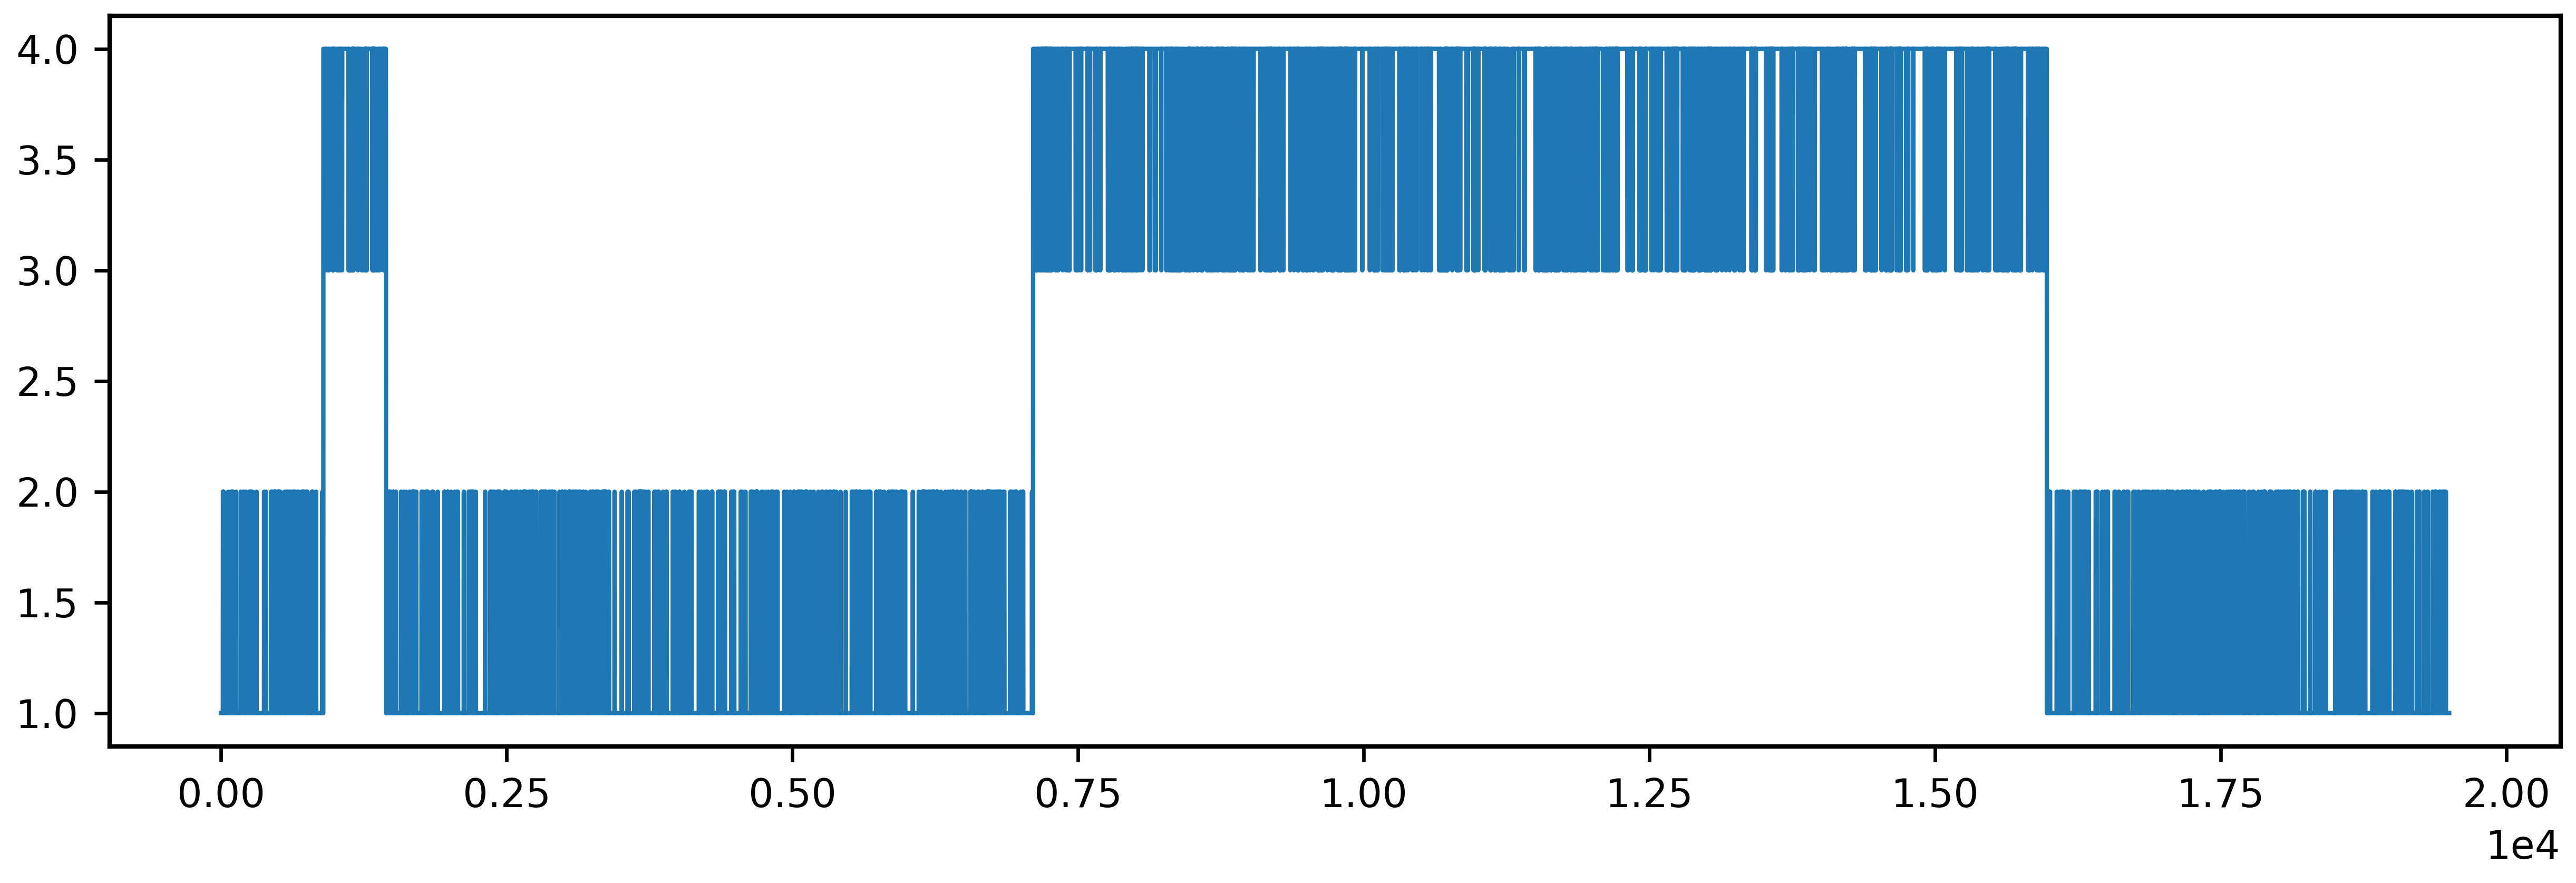

In [46]:
plt.figure(figsize=(10,3))
plt.plot(states[500:], color='tab:blue')
#plt.plot(np.arange(170,470), states[170:470], color='tab:red')
#plt.plot(np.arange(3030,3270), states[3030:3270], color='tab:red')


In [44]:
states

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
np.savetxt(path+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt', states[500:])

# Compute rates MSM

In [3]:
states = np.array([], dtype=int)
for s in range(1,6):
    tmp = np.loadtxt(path+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt').astype(int)
    states = np.append(states, tmp)

states

array([1, 1, 1, ..., 1, 1, 1])

In [52]:
models = []
lagtimes = [1,5,10,30,55,70]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=10, reversible=False).fit_fetch(counts))

### Implied timescales

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


(1.0, 70.0)

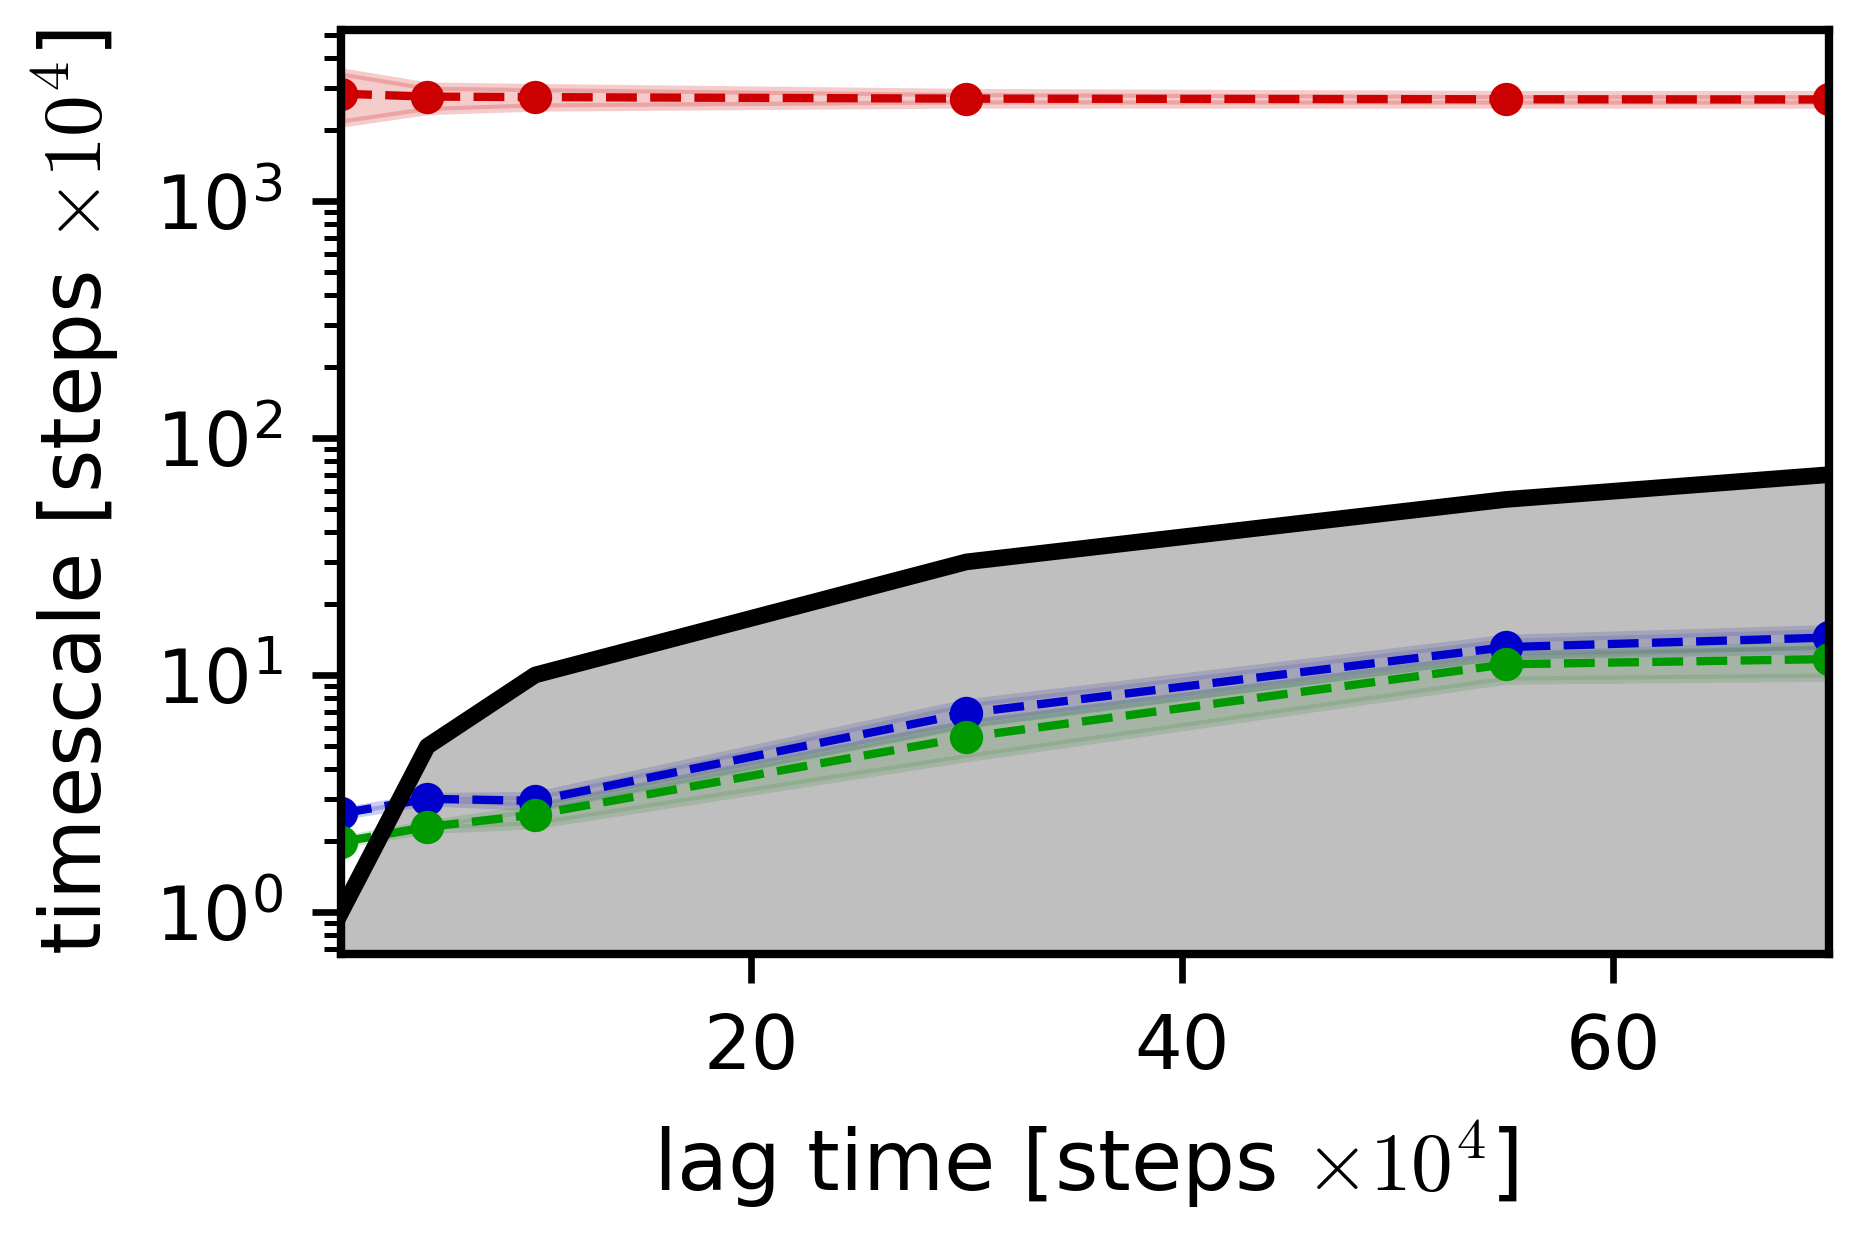

In [53]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,70)


In [4]:
# model with lagtime 10
msm = pyemma.msm.bayesian_markov_model(states, lag=10, reversible=False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5815.49it/s]


### Chapman-Kolmogorov test

In [6]:
# ck test for 3 state msm (state 1 and 4 are the same)
ck3 = msm.cktest(3, memberships=np.array([[1,0,0],[0,1,0],[0,0,1],[1,0,0]]))

# ck test for 3 state msm
ck4 = msm.cktest(4, memberships=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [16:15<00:00, 118.95s/it]Process SpawnPoolWorker-57:
Process SpawnPoolWorker-63:
Process SpawnPoolWorker-65:
Process SpawnPoolWorker-61:
Process SpawnPoolWorker-58:
Process SpawnPoolWorker-64:
Process SpawnPoolWorker-60:
Process SpawnPoolWorker-59:
Process SpawnPoolWorker-55:
Process SpawnPoolWorker-52:
Process SpawnPoolWorker-49:
Process SpawnPoolWorker-48:
Process SpawnPoolWorker-56:
Process SpawnPoolWorker-53:
Process SpawnPoolWorker-62:
Process SpawnPoolWorker-44:
Process SpawnPoolWorker-32:
Process SpawnPoolWorker-39:
Process SpawnPoolWorker-31:
Process SpawnPoolWorker-33:
Process SpawnPoolWorker-29:
Process SpawnPoolWorker-38:
Process SpawnPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (m

KeyboardInterrupt: 

Plots

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(3.8,3), sharex=True, sharey=True)
type(ax)
pred_conf_low = ck3.predictions_conf[0]
pred_conf_up = ck3.predictions_conf[1]
x = ck3.lagtimes

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, ck3.estimates[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(x, ck3.predictions[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(x, pred_conf_low[:,i,j], pred_conf_up[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(65,0.9, f'{i+1}->{j+1}', fontsize=8)

        if i==2 and j==1:
            ax[i,j].set_xlabel('lag time [steps]')
        if i==1 and j==0:
            ax[i,j].set_ylabel('probability')
            ax[i,j].legend(loc=(.75,2.28), ncols=2)

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(3.8,3), sharex=True, sharey=True)
type(ax)
pred_conf_low = ck4.predictions_conf[0]
pred_conf_up = ck4.predictions_conf[1]
x = ck3.lagtimes

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(x, ck4.estimates[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(x, ck4.predictions[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(x, pred_conf_low[:,i,j], pred_conf_up[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(55,0.85, f'{i+1}->{j+1}', fontsize=8)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)

In [ ]:
# Create a directed graph
G = nx.DiGraph()
tm = msm.transition_matrix

# Add nodes
G.add_nodes_from(range(4))
# Add edges according to the described connections
for i in range(4):
    G.add_edge(i, (i+1)%4)
    G.add_edge((i+1)%4, i)

widths=np.array([tm[0,1], tm[0,3], tm[1,0], tm[1,2], tm[2,1], tm[2,3], tm[3,2], tm[3,0]])
mw = np.min(widths)
Mw = np.max(widths)
widths= 0.4+9*(widths-mw)/(Mw-mw)

# positions
positions = np.array([(1,1),(1,-1),(-1,-1),(-1,1)])/100
pos_dict = dict()
label_dict = dict()
for i in range(4):
    pos_dict[i] = positions[i]
    label_dict[i] = f"{i+1}"


# Plot the graph
plt.figure(figsize=(3,3))
pos=nx.spectral_layout(G)
nx.draw(G, pos_dict, with_labels=True, arrowstyle='-|>',connectionstyle='arc3,rad=-0.25', labels=label_dict , arrowsize=30, node_color='lightblue', node_size=[msm.stationary_distribution[i]*7000 for i in range(4)], font_size=20, width=0.1)
nx.draw_networkx_edges(G, pos_dict, edgelist=[(1,0),(1,2),(3,2),(3,0)], arrowstyle='-',connectionstyle='arc3,rad=-0.25', arrowsize=30, node_size=[msm.stationary_distribution[i]*7000+2800*((i+1)%2) for i in range(4)], width=np.append(widths[2:4], widths[6:]))
nx.draw_networkx_edges(G, pos_dict, edgelist=[(0,1),(0,3),(2,1),(2,3)], arrowstyle='-',connectionstyle='arc3,rad=-0.25', arrowsize=30, node_size=[msm.stationary_distribution[i]*7000+2000*(i%2) for i in range(4)], width=np.append(widths[:2], widths[4:6]))


### Compute transition matrix and Delta mu

In [7]:
def average(sample, n_term=0):
    ''' sample average 
        parameter n_term: first n_term data are discarded
        '''
    return (sample[n_term:]).sum()/(len(sample)-n_term)
    
def sigma_simple(sample, n_term=0):
    ''' sample standard deviation with zero covariance
        parameter n_term: first n_term data are discarded
        '''
    mu = average(sample, n_term)
    N = len(sample) - n_term
    return np.sqrt(((sample[n_term:] - mu)**2).sum()/(N*(N-1)))


def sigma_blocking(sample, pow_bin=0,  n_term=0):
    ''' sample standard deviation with covariance estimate with data blocking technique 
        parameter n_term: first n_term data are discarded
        parameter pow_bin: block size = 2^pow_bin
        '''
    dim_bin = 2**pow_bin
    n_bin = int(( len(sample[n_term:]) )/ dim_bin)    
    N = n_bin * dim_bin
    
    mu = average(sample[n_term:n_term+N])
    sample_split = np.array_split(sample[n_term:n_term+N],n_bin)
    sum_block = (np.array([ ( average(sample[n_term+i*dim_bin : n_term+(i+1)*dim_bin]) - mu )**2 for i in range(n_bin) ]) ).sum()
    
    return np.sqrt(sum_block)*dim_bin/N

def autocorr_bin(sample, pow_bin_max=10, n_term=0):
    ''' plot of sigma_blocking for different pow_bin:
            correlation lenght estimate
            '''
    pow_bin = [x for x in range(pow_bin_max)]
    sigma = np.array([sigma_blocking(sample, x, n_term) for x in pow_bin])
    sigma = sigma/sigma[0]
    plt.figure(10)
    #plt.yscale('log')
    plt.grid(True)
    plt.plot(pow_bin, sigma)
    plt.xlabel('log$_{10}$ correlation block size')
    plt.ylabel('error estimate with blocking')
    plt.show()

In [8]:
def dmu_estimate(dtraj, lag=1, kT=3*0.831446, n_term=0):
    msm = pyemma.msm.bayesian_markov_model(dtraj, lag=lag, reversible=False)
    t_matrix = msm.transition_matrix
    matrix_size = len(t_matrix)
    cycle = t_matrix[matrix_size-1,0]
    anti_cycle = t_matrix[0,matrix_size-1]
    for i in range(matrix_size-1):
        cycle *= t_matrix[i,i+1]
        anti_cycle *= t_matrix[i+1,i]
    return kT*np.log(cycle/anti_cycle)

def bootstrap_dmu_estimate(dtraj, lag=1, pow_bin=0, n_resample=100, n_term=0):
    dim_bin = int(2**pow_bin)
    n_bin = int(( len(dtraj)-n_term )/ dim_bin)    
    N = n_bin * dim_bin
    dtraj_list = np.reshape( dtraj[n_term: n_term+N], (n_bin, dim_bin) )
    
    rnd_matrix = np.random.randint(n_bin, size=(n_resample,n_bin))

    dtraj_resample = np.array([ np.reshape( np.array([ dtraj_list[i] for i in rnd_matrix[k] ]), N ) for k in range(n_resample) ])
    
    mu = np.array([ dmu_estimate(dtraj_resample[i], lag=lag) for i in range(n_resample) ])
    
    return np.sqrt(((mu - average(mu))**2).sum()/n_resample)

In [9]:
def split_dmu_estimates(dtraj, lag=1, kT=3*0.831446, n_term=0):
    msm = pyemma.msm.bayesian_markov_model(dtraj, lag=lag, reversible=False)
    t_matrix = msm.transition_matrix
    matrix_size = len(t_matrix)
    dmu_contributions = np.zeros(matrix_size)

    for i in range(matrix_size):
        dmu_contributions[i] = t_matrix[i,(i+1)%matrix_size]/t_matrix[(i+1)%matrix_size,i]

    return list( kT*np.log( dmu_contributions ) )

def bootstrap_split_dmu_estimates(dtraj, lag=1, pow_bin=0, n_resample=100, kT=3*0.831446, n_term=0):
    dim_bin = int(2**pow_bin)
    n_bin = int(( len(dtraj)-n_term )/ dim_bin)    
    N = n_bin * dim_bin
    dtraj_list = np.reshape( dtraj[n_term: n_term+N], (n_bin, dim_bin) )
    
    rnd_matrix = np.random.randint(n_bin, size=(n_resample,n_bin))

    dtraj_resample = np.array([ np.reshape( np.array([ dtraj_list[i] for i in rnd_matrix[k] ]), N ) for k in range(n_resample) ])
    
    mu = np.array([ split_dmu_estimates(dtraj_resample[i], lag=lag, kT=kT) for i in range(n_resample) ])
    
    return np.sqrt(np.sum((mu - np.sum(mu, axis=0)/n_resample)**2, axis=0)/n_resample)



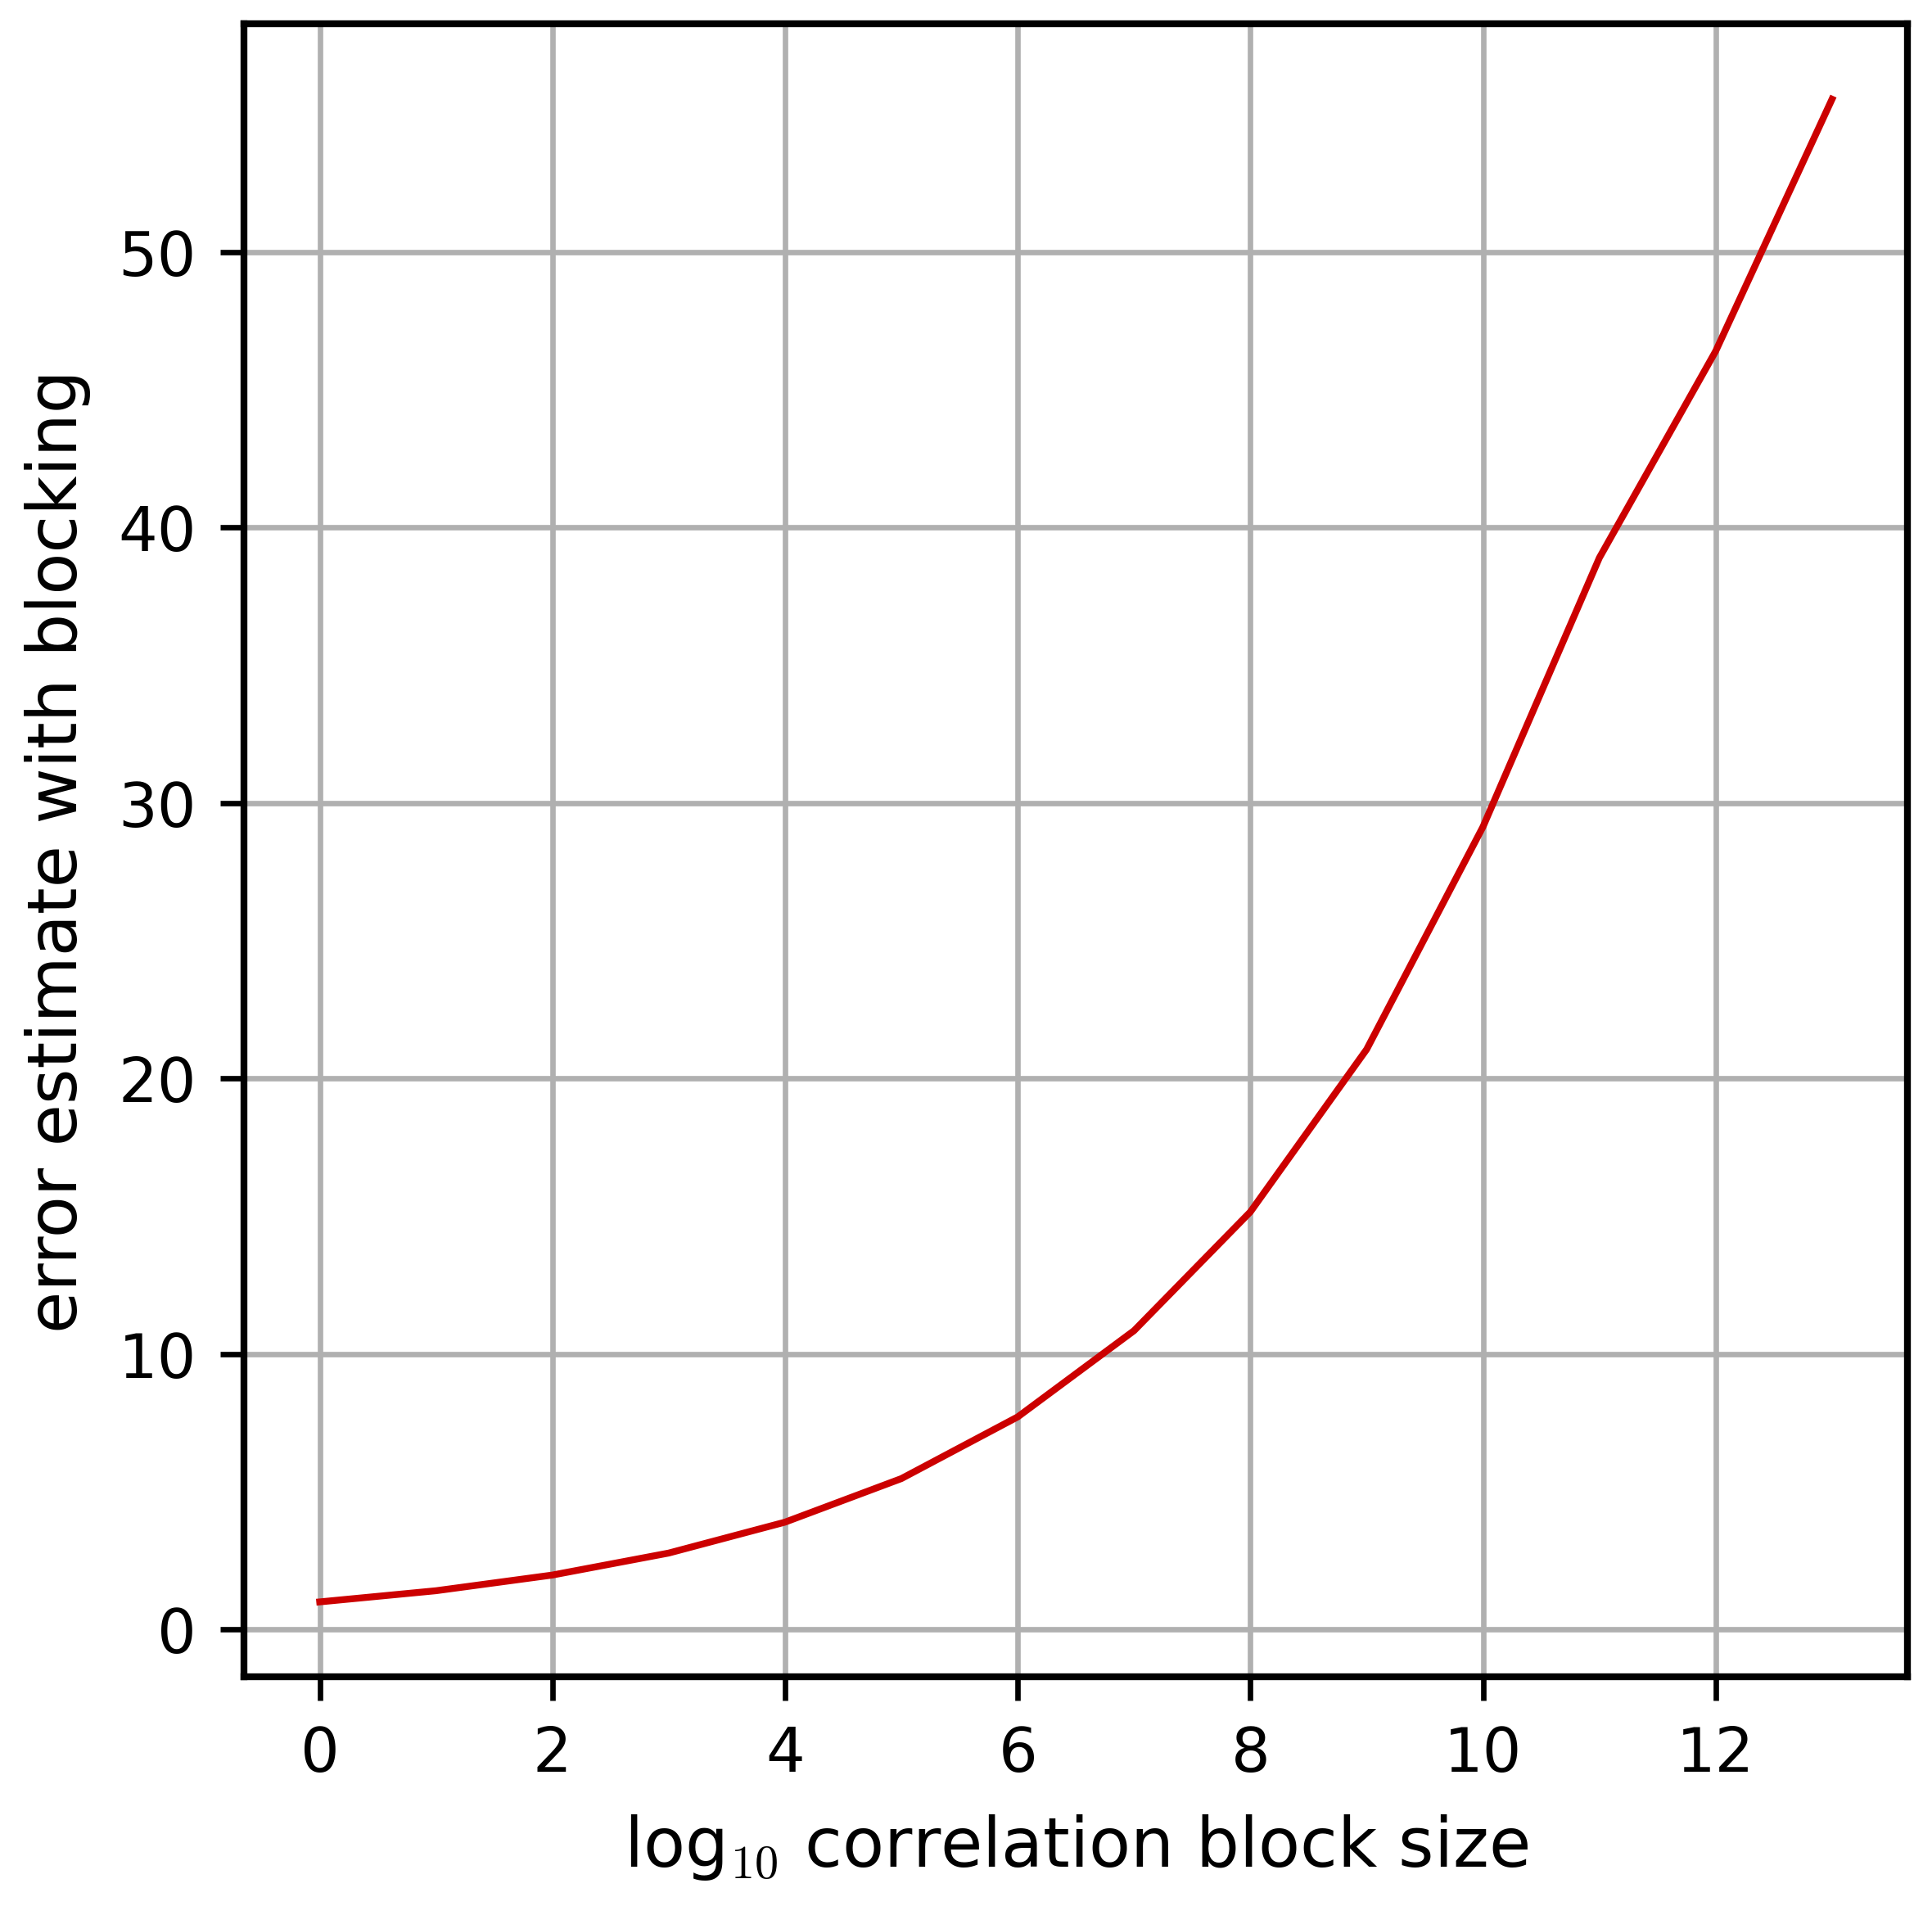

In [10]:
autocorr_bin(states, 14, 1000)

In [11]:
dmu = dmu_estimate(states, lag=10, n_term=1000)
sigma_dmu = bootstrap_dmu_estimate(states, lag=10, pow_bin=10, n_resample=30, n_term=1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4409.02it/s]
/tmp/ipykernel_203879/1206797859.py:10: RuntimeWarning: divide by zero encountered in log
  return kT*np.log(cycle/anti_cycle)
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7521.66it/s]
/tmp/ipykernel_203879/1206797859.py:24: RuntimeWarning: invalid value encountered in subtract
  return np.sqrt(((mu - average(mu))**2).sum()/n_resample)


In [12]:
print(dmu, sigma_dmu)

0.38804598748933405 nan


Estimate with 3-states MSM

In [98]:
states3 = np.copy(states)
states3[np.where(states3==4)] = 1

dmu = dmu_estimate(states3, lag=10, n_term=1000)
sigma_dmu = bootstrap_dmu_estimate(states3, lag=10, pow_bin=10, n_resample=30, n_term=1000)
print(dmu, sigma_dmu)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1188.59it/s]

5.0583491589032885 0.4774151299959109


### Comparison Delta mu estimated  and Delta mu expected

In [22]:
data = np.loadtxt('single_ser_ness.txt')

In [23]:
def linear(x, a,b):
    return a*x + b

mux = data[:,1]
muy = data[:,2]
d_muy = data[:,3]

popt,pcov = curve_fit(linear, mux,muy)
err = np.sqrt(pcov.diagonal())
print(popt, err)

[0.9905     0.03861111] [0.02362514 0.15249955]


([<matplotlib.axis.XTick at 0x7f00a21cd480>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10')])

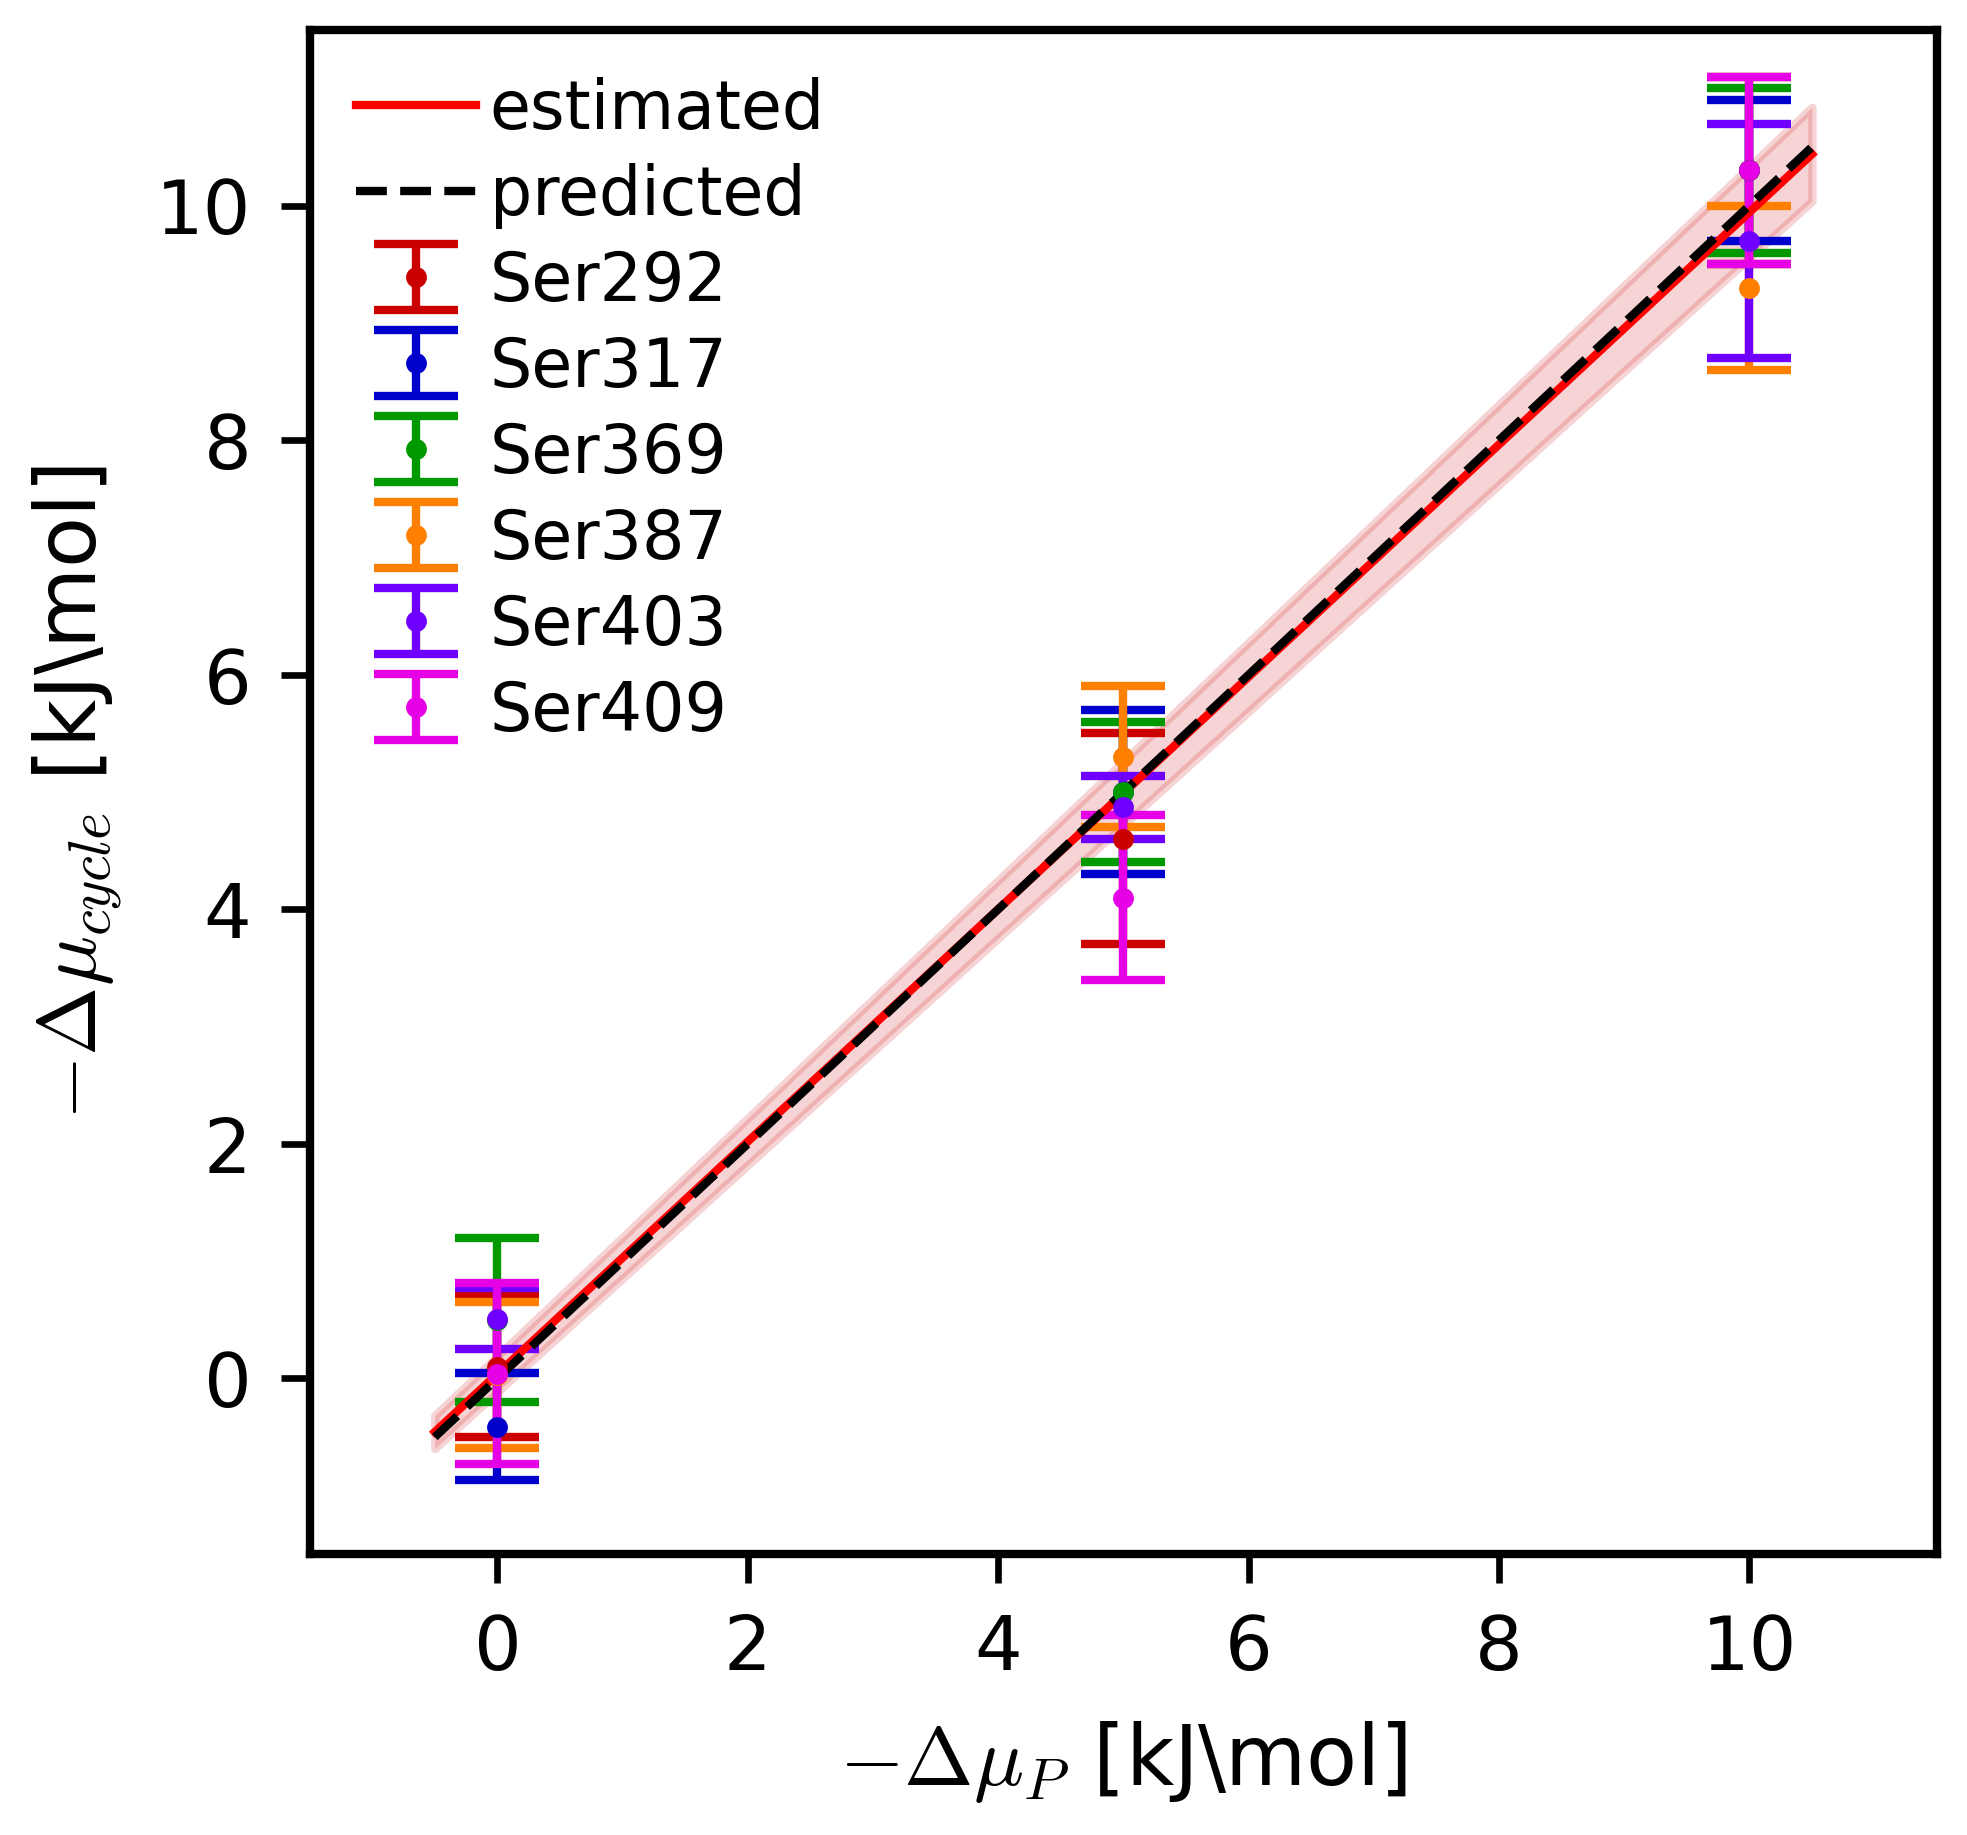

In [25]:
ser_l = [292,317,369,387,403,409]
x = np.array([-0.5,10.5])
y = linear(x, *popt)

plt.figure(figsize=(3.5,3.3))
for i,s in enumerate([2,4,10,15,19,22]):
    plt.errorbar(data[np.where(data[:,0]==s)][:,1], data[np.where(data[:,0]==s)][:,2], data[np.where(data[:,0]==s)][:,3], fmt='.', capsize=5, label=f'Ser{ser_l[i]}')

plt.plot(x, y, '-r', label='estimated')
plt.fill_between(x, y-err[1]-err[0]*x, y+err[1]+err[0]*x, alpha=0.2, color='tab:red')
plt.plot(x, x, '--k',  label='predicted')
plt.legend()
plt.xlabel('$- \Delta \mu_P$ [kJ\mol]')
plt.ylabel('$- \Delta \mu_{cycle}$ [kJ\mol]')
plt.ylim(-1.5,11.5)
plt.xlim(-1.5,11.5)
plt.xticks([0,2,4,6,8,10], [0,2,4,6,8,10])

### SI plots

In [30]:
n_ser = 19

dmu = 0
states0 = np.loadtxt(path+f"sim_ser{n_ser}_split/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_states.txt", dtype=int)
msm0 = pyemma.msm.bayesian_markov_model(states0, lag=10, reversible=False)
tm0 = msm0.sample_mean('transition_matrix')
d_tm0 = msm0.sample_std('transition_matrix')
p0 = msm0.sample_mean('stationary_distribution')
d_p0 = msm0.sample_std('stationary_distribution')

dmu = -5
states5 = np.loadtxt(path+f"sim_ser{n_ser}_split/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_states.txt", dtype=int)
msm5 = pyemma.msm.bayesian_markov_model(states5, lag=10, reversible=False)
tm5 = msm5.sample_mean('transition_matrix')
d_tm5 = msm5.sample_std('transition_matrix')
p5 = msm5.sample_mean('stationary_distribution')
d_p5 = msm5.sample_std('stationary_distribution')

dmu = -10
states10 = np.loadtxt(path+f"sim_ser{n_ser}/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_states.txt", dtype=int)
msm10 = pyemma.msm.bayesian_markov_model(states10, lag=10, reversible=False)
tm10 = msm10.sample_mean('transition_matrix')
d_tm10 = msm10.sample_std('transition_matrix')
p10 = msm10.sample_mean('stationary_distribution')
d_p10 = msm10.sample_std('stationary_distribution')

/tmp/ipykernel_3969259/1608718685.py:4: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  states0 = np.loadtxt(path+f"sim_ser{n_ser}_split/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_states.txt", dtype=int)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1078.20it/s]
/tmp/ipykernel_3969259/1608718685.py:12: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the origina

In [33]:
dmu_split0 = split_dmu_estimates(states0, lag=10, n_term=1000)
sigma_dmu_split0 = bootstrap_split_dmu_estimates(states0, lag=1, pow_bin=12, n_resample=15, n_term=1000)

dmu_split5 = split_dmu_estimates(states5, lag=10, n_term=1000)
sigma_dmu_split5 = bootstrap_split_dmu_estimates(states5, lag=1, pow_bin=12, n_resample=15, n_term=1000)

dmu_split10 = split_dmu_estimates(states10, lag=10, n_term=1000)
sigma_dmu_split10 = bootstrap_split_dmu_estimates(states10, lag=1, pow_bin=12, n_resample=15, n_term=1000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1091.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1145.67it/s]


(-2.0, 11.0)

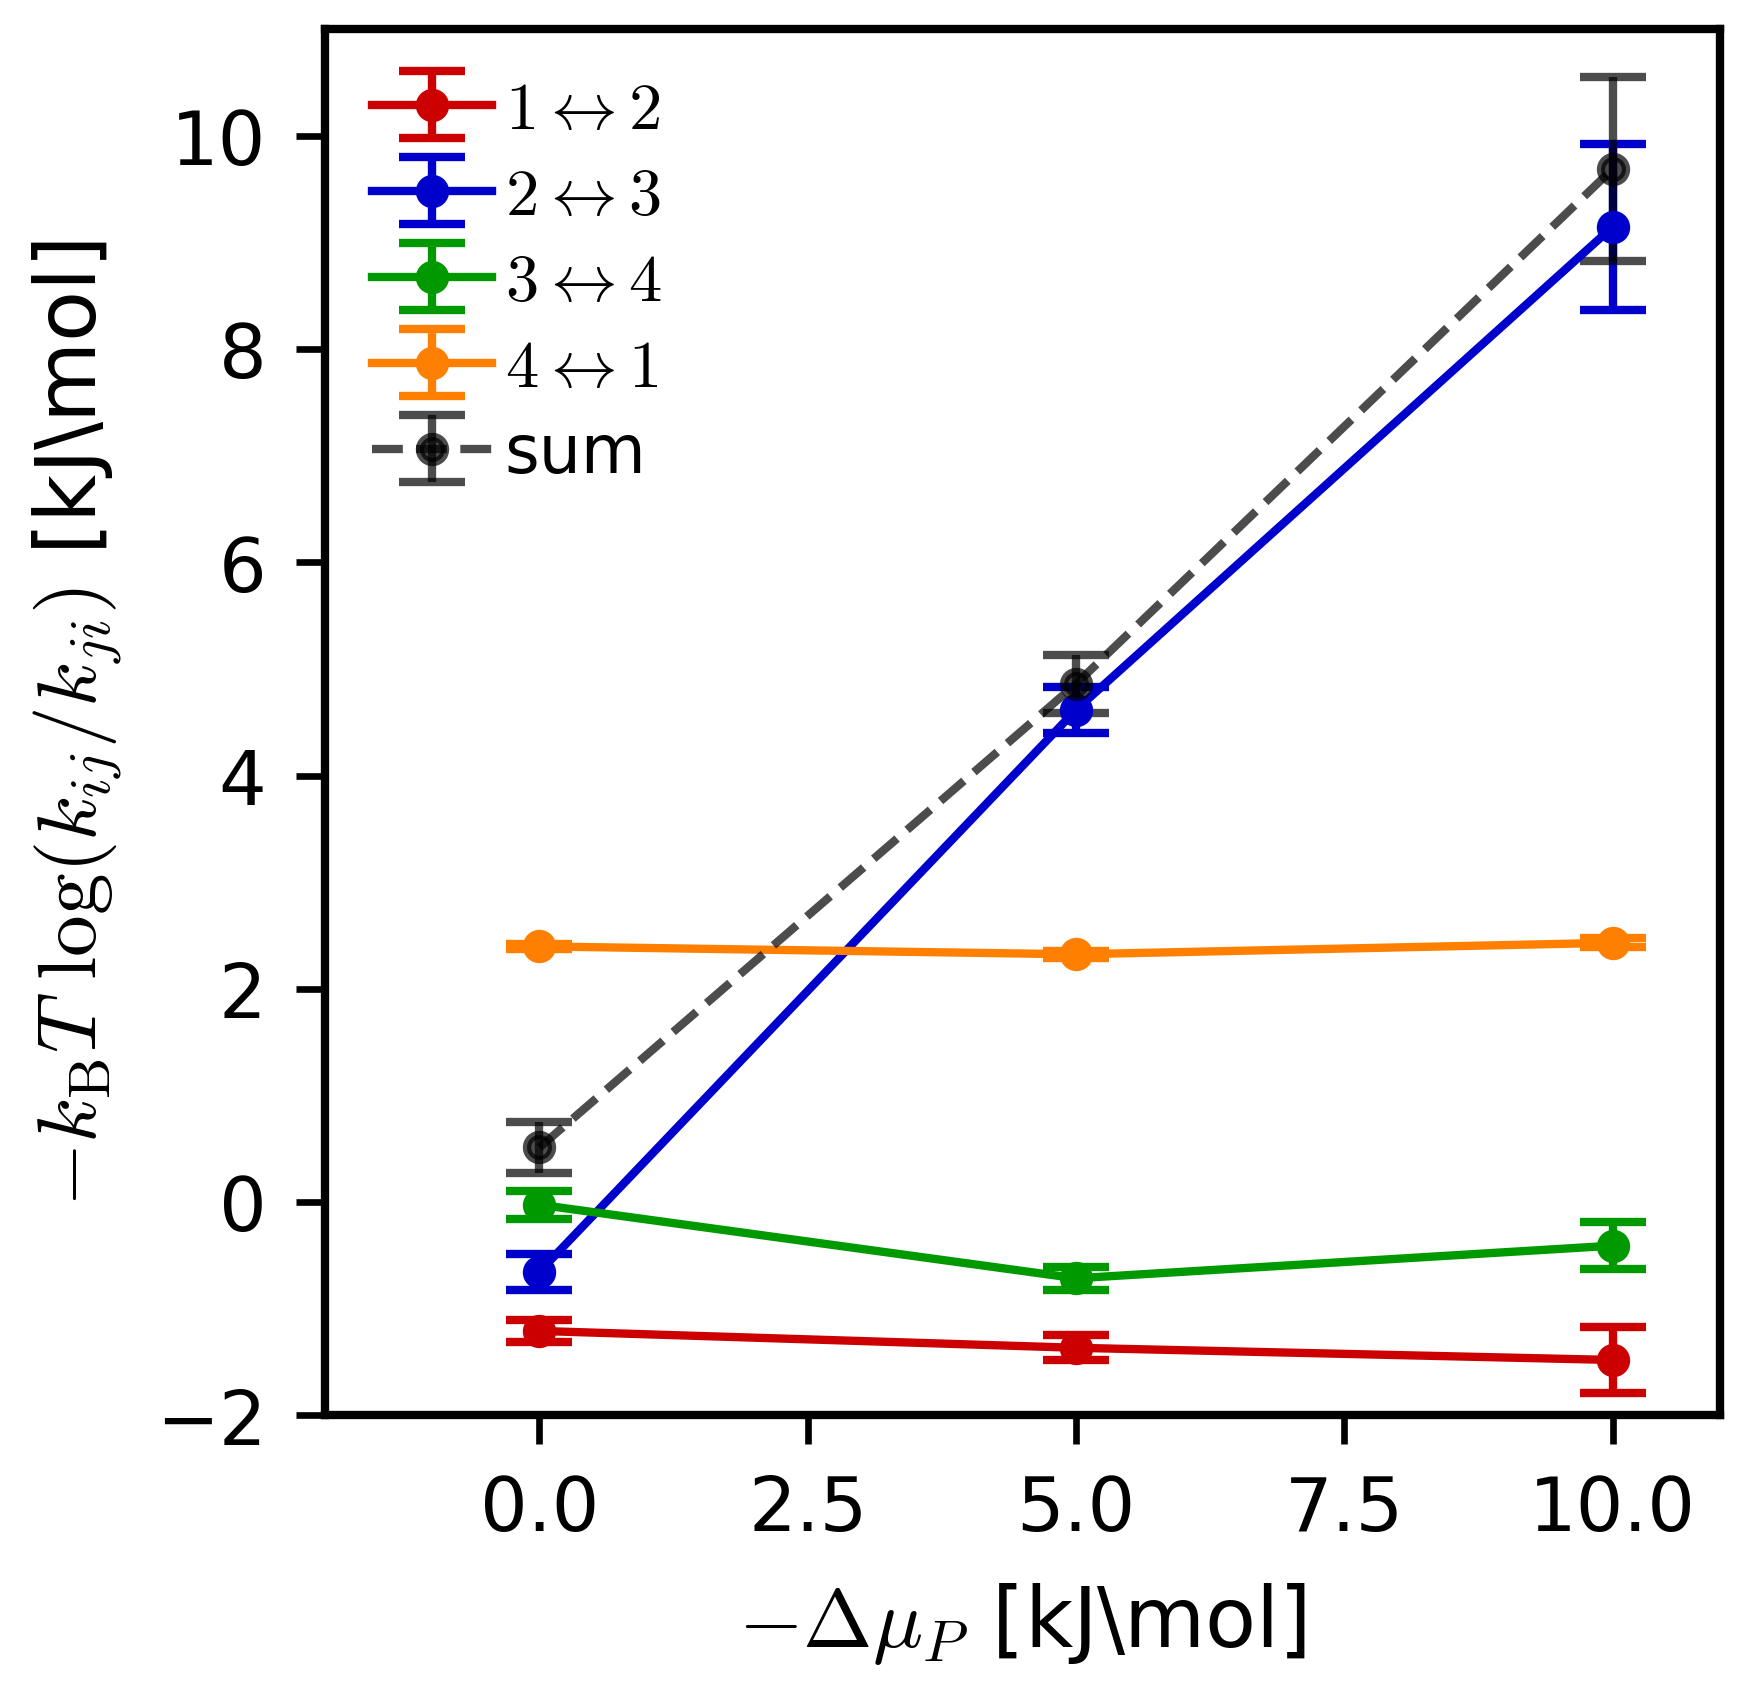

In [34]:
plt.figure(figsize=(3,3))
plt.errorbar([0,5,10], [dmu_split0[0],dmu_split5[0],dmu_split10[0]], [sigma_dmu_split0[0],sigma_dmu_split5[0],sigma_dmu_split10[0]], capsize=4, fmt='o-', label=r'$1 \leftrightarrow 2$')
plt.errorbar([0,5,10], [dmu_split0[1],dmu_split5[1],dmu_split10[1]], [sigma_dmu_split0[1],sigma_dmu_split5[1],sigma_dmu_split10[1]], capsize=4, fmt='o-',label=r'$2 \leftrightarrow 3$')
plt.errorbar([0,5,10], [dmu_split0[2],dmu_split5[2],dmu_split10[2]], [sigma_dmu_split0[2],sigma_dmu_split5[2],sigma_dmu_split10[2]], capsize=4, fmt='o-',label=r'$3 \leftrightarrow 4$')
plt.errorbar([0,5,10], [dmu_split0[3],dmu_split5[3],dmu_split10[3]], [sigma_dmu_split0[3],sigma_dmu_split5[3],sigma_dmu_split10[3]], capsize=4, fmt='o-',label=r'$4 \leftrightarrow 1$')
plt.errorbar([0,5,10], [np.sum(dmu_split0),np.sum(dmu_split5),np.sum(dmu_split10)], [np.sqrt(np.sum(sigma_dmu_split0**2)),np.sqrt(np.sum(sigma_dmu_split5**2)), np.sqrt(np.sum(sigma_dmu_split10**2))], capsize=4, fmt='o--k', alpha=0.7, label=r'sum')

#plt.xticks([0,5,10],[0,5,10])
plt.xlabel('$- \Delta \mu_P$ [kJ\mol]')
plt.ylabel('$- k_\mathrm{B } T~ \log(k_{ij}/k_{ji})$ [kJ\mol]')

plt.legend(ncols=1)
plt.xlim(-2,11.)
plt.ylim(-2,11.)

In [26]:
path = ''

dt_dist = '20000'
states20000 = np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_states.txt", dtype=int)
states20000 = np.append(states20000, np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_1_states.txt", dtype=int), axis=0)

dt_dist = '2000'
states2000 = np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_states.txt", dtype=int)
states2000 = np.append(states2000, np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_1_states.txt", dtype=int), axis=0)

dt_dist = '1000'
states1000 = np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_states.txt", dtype=int)
states1000 = np.append(states1000, np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_1_states.txt", dtype=int), axis=0)

dt_dist = '100'
states100 = np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_states.txt", dtype=int)
states100 = np.append(states100, np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_1_states.txt", dtype=int), axis=0)

dt_dist = '400'
states400 = np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_states.txt", dtype=int)
states400 = np.append(states400, np.loadtxt(path+f"sim_ser19_time_dist/sim_ser19_ck1d-open_tdp43_time_dist{dt_dist}_1_states.txt", dtype=int), axis=0)


In [27]:
msm100 = pyemma.msm.bayesian_markov_model(states100, lag=10, reversible=False)
tm100 = msm100.sample_mean('transition_matrix')
d_tm100 = msm100.sample_std('transition_matrix')
p100 = msm100.sample_mean('stationary_distribution')
d_p100 = msm100.sample_std('stationary_distribution')

msm1000 = pyemma.msm.bayesian_markov_model(states1000, lag=10, reversible=False)
tm1000 = msm1000.sample_mean('transition_matrix')
d_tm1000 = msm1000.sample_std('transition_matrix')
p1000 = msm1000.sample_mean('stationary_distribution')
d_p1000 = msm1000.sample_std('stationary_distribution')

msm400 = pyemma.msm.bayesian_markov_model(states400, lag=10, reversible=False)
tm400 = msm400.sample_mean('transition_matrix')
d_tm400 = msm400.sample_std('transition_matrix')
p400 = msm400.sample_mean('stationary_distribution')
d_p400 = msm400.sample_std('stationary_distribution')

msm2000 = pyemma.msm.bayesian_markov_model(states2000, lag=10, reversible=False)
tm2000 = msm2000.sample_mean('transition_matrix')
d_tm2000 = msm2000.sample_std('transition_matrix')
p2000 = msm2000.sample_mean('stationary_distribution')
d_p2000 = msm2000.sample_std('stationary_distribution')

msm20000 = pyemma.msm.bayesian_markov_model(states20000, lag=10, reversible=False)
tm20000 = msm20000.sample_mean('transition_matrix')
d_tm20000 = msm20000.sample_std('transition_matrix')
p20000 = msm20000.sample_mean('stationary_distribution')
d_p20000 = msm20000.sample_std('stationary_distribution')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1109.43it/s]


In [35]:
dmu_split100 = split_dmu_estimates(states100, lag=10, n_term=1000)
sigma_dmu_split100 = bootstrap_split_dmu_estimates(states100, lag=1, pow_bin=12, n_resample=15, n_term=1000)

dmu_split400 = split_dmu_estimates(states400, lag=10, n_term=1000)
sigma_dmu_split400 = bootstrap_split_dmu_estimates(states400, lag=1, pow_bin=12, n_resample=15, n_term=1000)

dmu_split1000 = split_dmu_estimates(states1000, lag=10, n_term=1000)
sigma_dmu_split1000 = bootstrap_split_dmu_estimates(states1000, lag=1, pow_bin=12, n_resample=15, n_term=1000)

dmu_split2000 = split_dmu_estimates(states2000, lag=10, n_term=1000)
sigma_dmu_split2000 = bootstrap_split_dmu_estimates(states2000, lag=1, pow_bin=12, n_resample=15, n_term=1000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1100.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1130.99it/s]


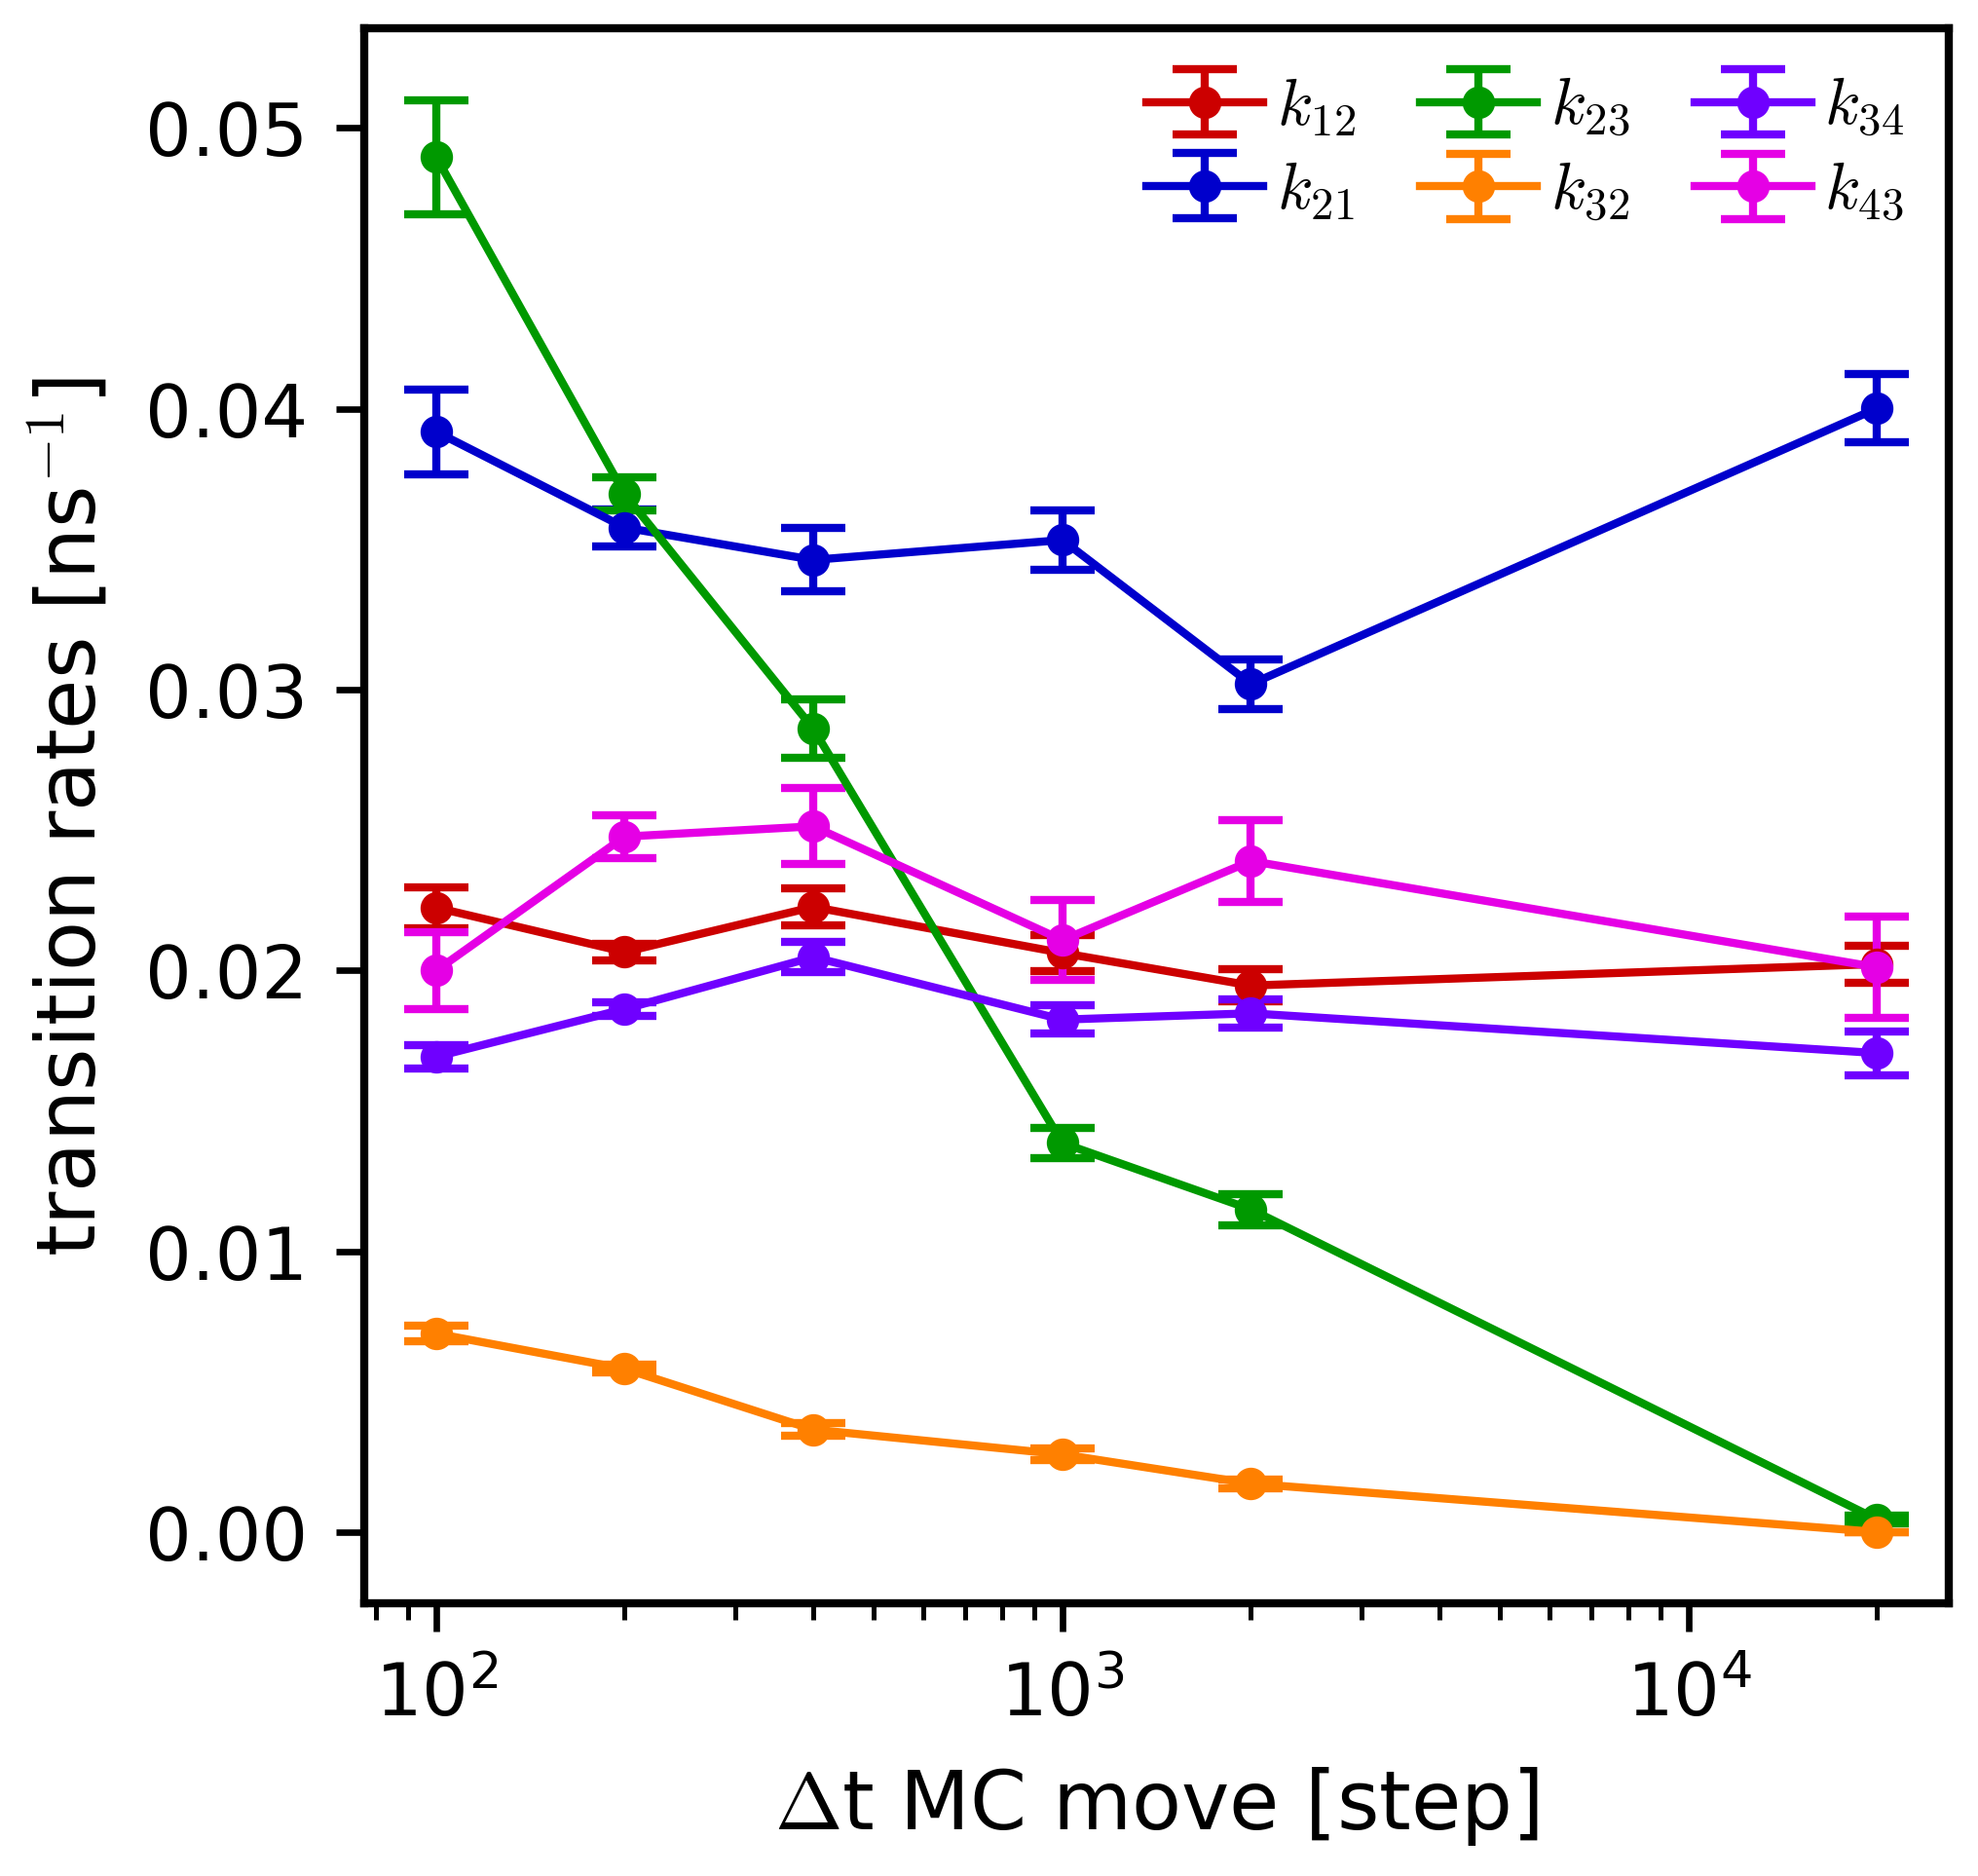

In [36]:
plt.figure(figsize=(3.5,3.5))

dt_dist_l = [100,200,400,1000,2000,20000]
tm_l = np.array([tm100,tm5,tm400,tm1000,tm2000,tm20000])
d_tm_l = np.array([d_tm100,d_tm5,d_tm400,d_tm1000,d_tm2000,d_tm20000])

plt.errorbar(dt_dist_l, tm_l[:,0,1], d_tm_l[:,0,1], fmt='o-', capsize=4, label=r'$k_{12}$')
plt.errorbar(dt_dist_l, tm_l[:,1,0], d_tm_l[:,1,0], fmt='o-', capsize=4, label=r'$k_{21}$')
plt.errorbar(dt_dist_l, tm_l[:,1,2], d_tm_l[:,1,2], fmt='o-', capsize=4, label=r'$k_{23}$')
plt.errorbar(dt_dist_l, tm_l[:,2,1], d_tm_l[:,2,1], fmt='o-', capsize=4, label=r'$k_{32}$')
plt.errorbar(dt_dist_l, tm_l[:,2,3], d_tm_l[:,2,3], fmt='o-', capsize=4, label=r'$k_{34}$')
plt.errorbar(dt_dist_l, tm_l[:,3,2], d_tm_l[:,3,2], fmt='o-', capsize=4, label=r'$k_{43}$')

plt.xticks(dt_dist_l,dt_dist_l)
plt.xlabel('$\Delta$t MC move [step]')
plt.ylabel('transition rates [ns$^{-1}$]')
plt.xscale('log')
#plt.ylim(-0.002,0.047)

plt.legend(ncols=3)

(-1.9, 6.1)

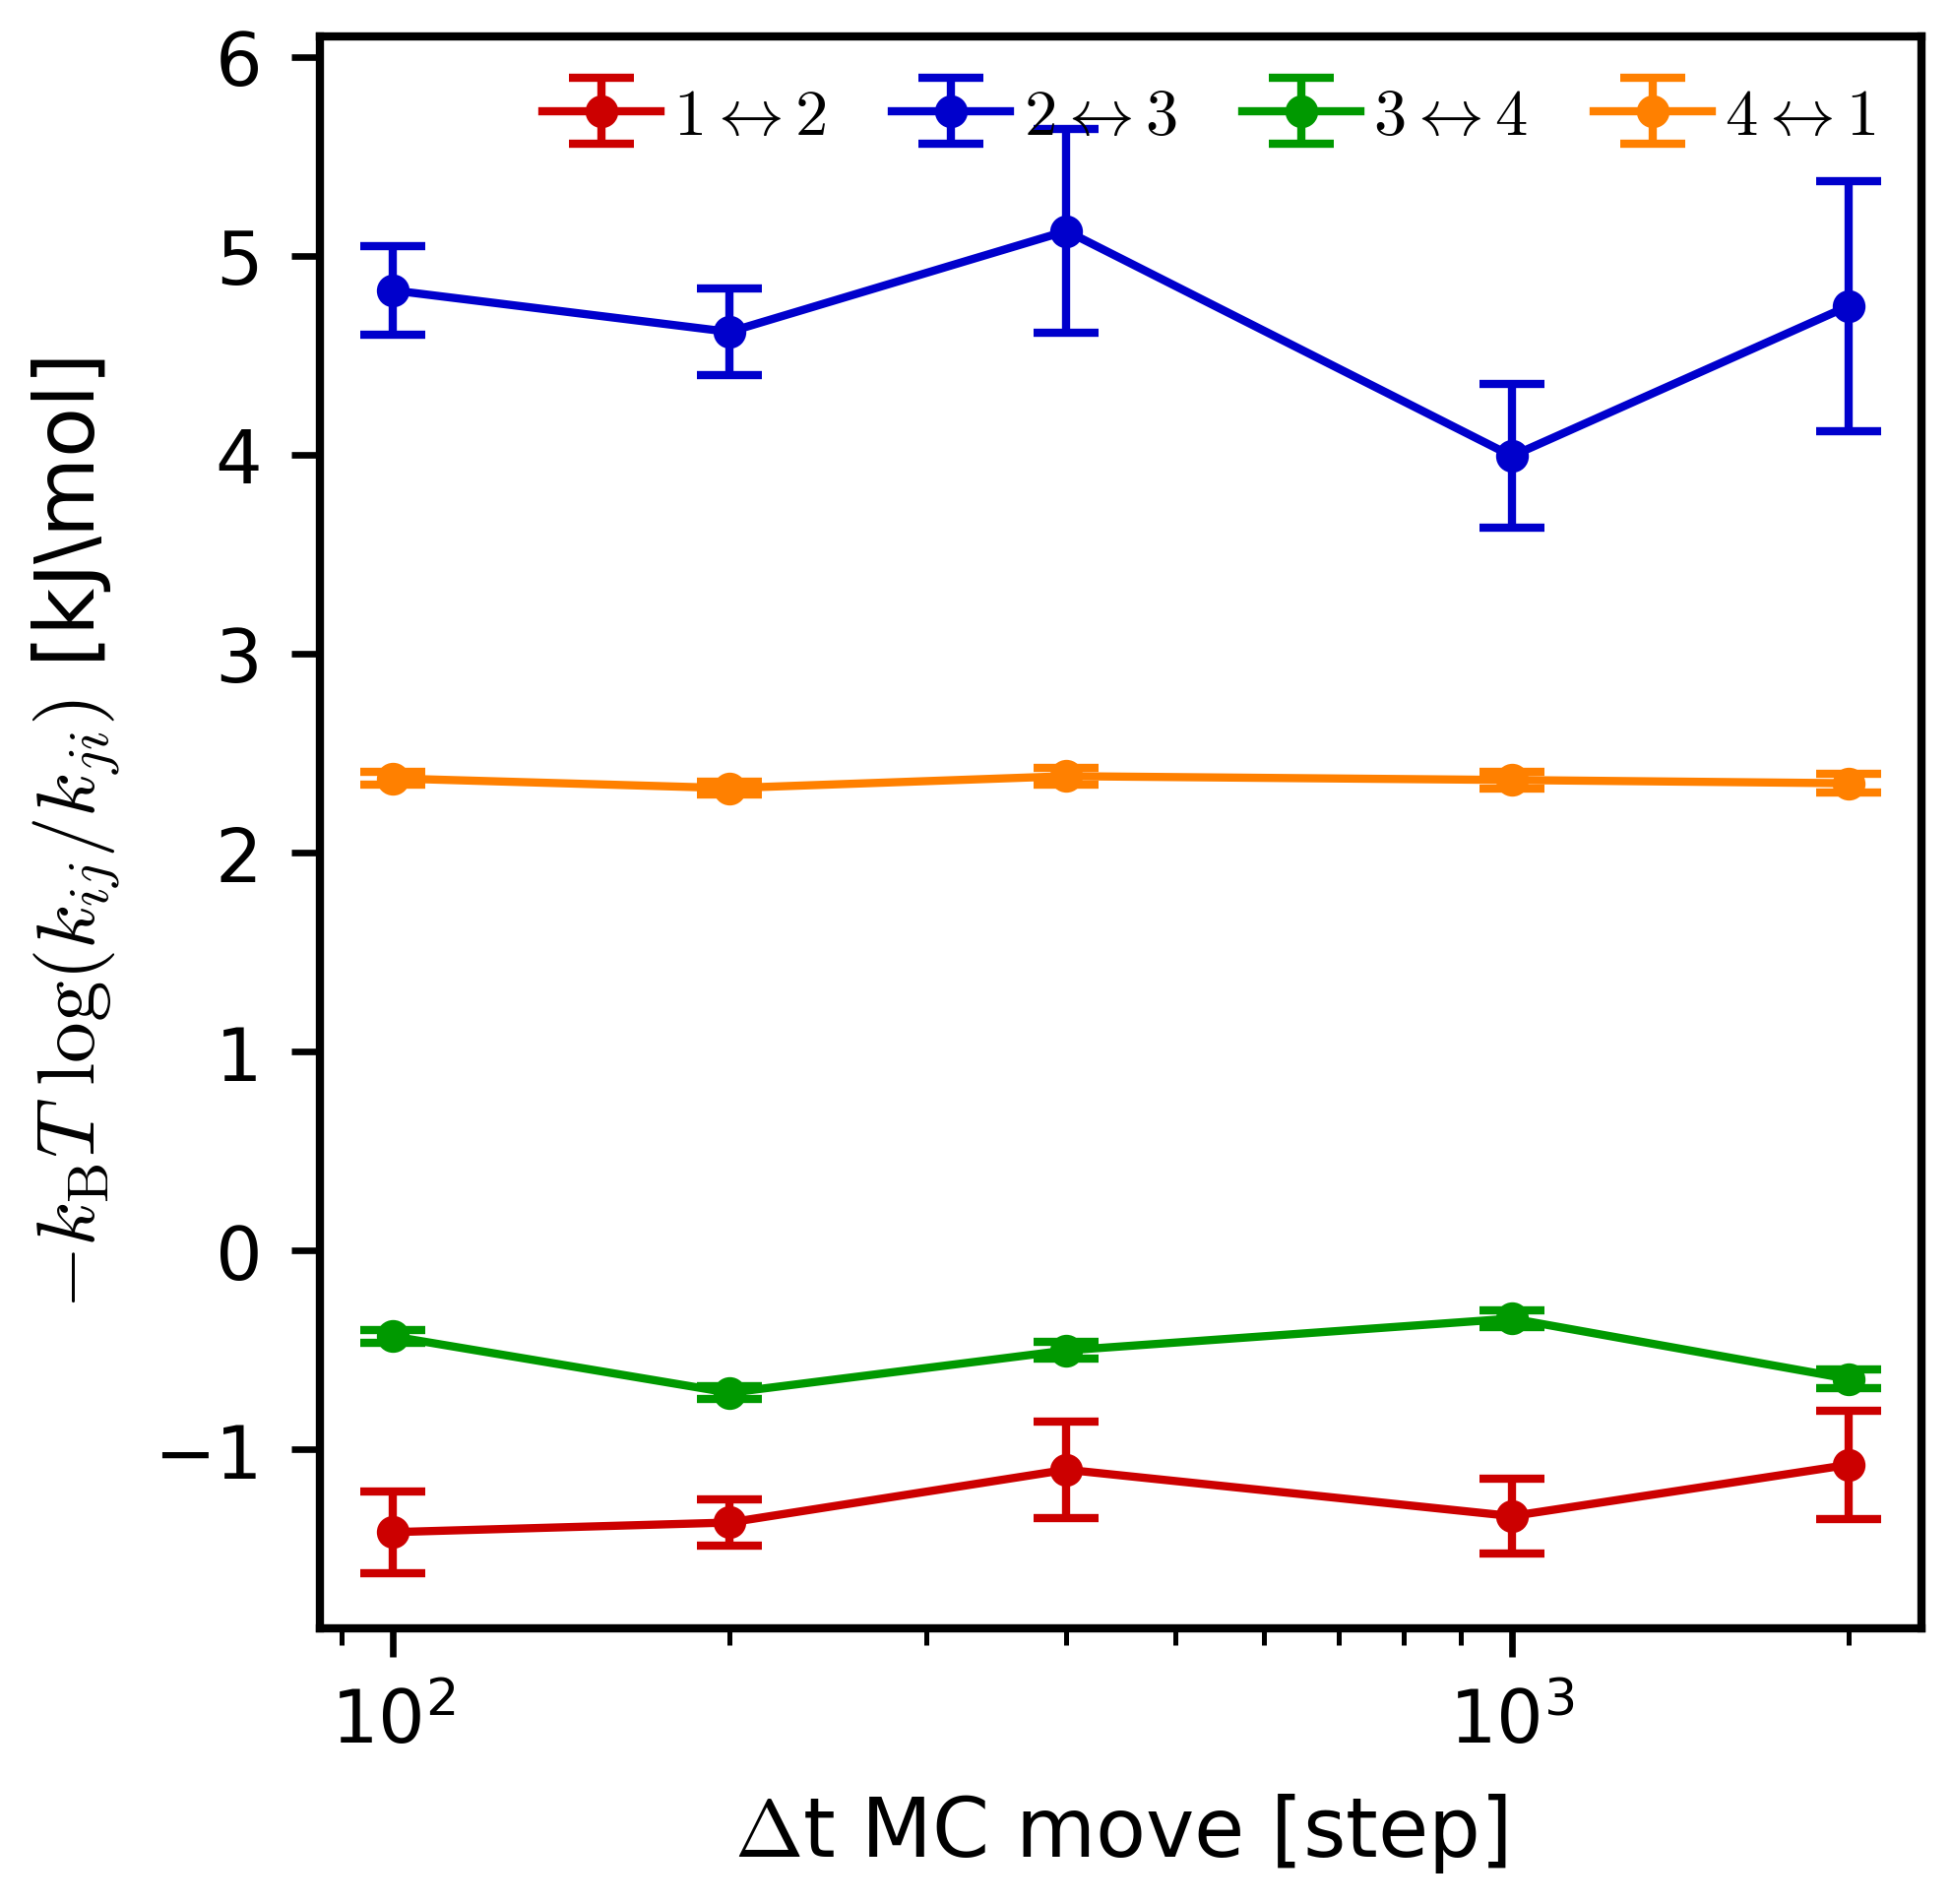

In [37]:
plt.figure(figsize=(3.5,3.5))

dt_dist_l = [100,200,400,1000,2000]
tm_l = np.array([dmu_split100,dmu_split5,dmu_split400,dmu_split1000,dmu_split2000])
d_tm_l = np.array([sigma_dmu_split100,sigma_dmu_split5,sigma_dmu_split400,sigma_dmu_split1000,sigma_dmu_split2000])

plt.errorbar(dt_dist_l, tm_l[:,0], d_tm_l[:,0], capsize=4, fmt='o-', label=r'$1 \leftrightarrow 2$')
plt.errorbar(dt_dist_l, tm_l[:,1], d_tm_l[:,1], capsize=4, fmt='o-',label=r'$2 \leftrightarrow 3$')
plt.errorbar(dt_dist_l, tm_l[:,2], d_tm_l[:,3], capsize=4, fmt='o-',label=r'$3 \leftrightarrow 4$')
plt.errorbar(dt_dist_l, tm_l[:,3], d_tm_l[:,3], capsize=4, fmt='o-',label=r'$4 \leftrightarrow 1$')

#plt.xticks([0,5,10],[0,5,10])
plt.xlabel('$\Delta$t MC move [step]')
plt.ylabel('$- k_\mathrm{B } T~ \log(k_{ij}/k_{ji})$ [kJ\mol]')
plt.xscale('log')
plt.legend(ncols=4)
plt.ylim(-1.9,6.1)
